---
### Assignment 4
Collect  tweets  published  via  Endomondo  by  people  from  3-4  major  cities  in Poland.   Check  if  there  are  some  differences  in  types  of  activities  between them.  Visualize the activity areas on a map.

---

*Importing of all necessary libaries.*

In [1]:
import json  # For reading configuartion file
import tweepy  # For connecting to tweeter API
import regex
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rc('font', family='Lato', size=16)

Authentication keys and tokens are stored locally to not share then with other people.

In [3]:
# Getting the authentication keys and tokens
with open('twitter_config.json', mode='r') as file:
    config = json.load(file)

Now we can authenticate using `tweepy`

In [4]:
# Authenticating to Twitter
auth = tweepy.OAuthHandler(config['consumerKey'], config['consumerSecret'])
auth.set_access_token(config['accessToken'], config['accessTokenSecret'])

and create and `api` object, which we will use for making requests.

In [5]:
# Creating an API object
api = tweepy.API(auth)
# api.verify_credentials()

### Obtaining the data

We will define a dictionary with largest Polish cities and their geographic locations (latitude and longitude). The data comes from Wikimedia Toolforge Geohack.

In [6]:
LOCATIONS = {
    'Warszawa': (52.232222, 21.008333),
    'Kraków': (50.061389, 19.938333),
    'Łódź': (51.776667, 19.454722),
    'Wrocław': (51.11, 17.022222),
    'Poznań': (52.408333, 16.934167),
    'Gdańsk': (54.3475, 18.645278 ),
    'Szczecin': (53.438056, 14.542222 ),
    'Bydgoszcz': (53.125, 18.011111 ),
    'Lublin': (51.248056, 22.570278 ),
    'Białystok': (53.135278, 23.145556 ),
}

And now we will fetch all tweets conatining hashtag *#Endomondo* and their locations which were posted at most 20km from center of those cities (so the user had to have the automatic posting and geolocation turned on!).

20km seems like a reasonable radius - it should catch all tweets from those cities and not those from their neighbourhood (for example in Tricity *(Trójmiasto)* we would be catching much more than Gdańsk).

In [7]:
city_data = {city: [] for city in LOCATIONS}
for city, (lat, lon) in LOCATIONS.items():
    response = api.search(q='#Endomondo #endorphins', 
                         geocode=f'{lat},{lon},20km', 
                         count=150)
    for tweet in response:
        city_data[city].append({
            'text': tweet.text,
            'lat': tweet.geo['coordinates'][0] if tweet.geo else None,
            'lon': tweet.geo['coordinates'][1] if tweet.geo else None
        })

As we might have suspected, we don't have too much data.

In [8]:
{city: len(tweets) for city, tweets in city_data.items()}

{'Warszawa': 44,
 'Kraków': 17,
 'Łódź': 8,
 'Wrocław': 14,
 'Poznań': 20,
 'Gdańsk': 5,
 'Szczecin': 2,
 'Bydgoszcz': 1,
 'Lublin': 3,
 'Białystok': 2}

If we look for example at Warsaw

In [9]:
city_data['Warszawa'][:5]

[{'text': 'I was out cycling 10.10 km with #Endomondo #endorphins https://t.co/JSLVjH1dE4',
  'lat': 52.1724769,
  'lon': 21.1145725},
 {'text': 'I was out running 12.02 km with #Endomondo #endorphins https://t.co/SKsSJT85rr',
  'lat': 52.23574346,
  'lon': 21.03784103},
 {'text': 'I was out swimming with #Endomondo #endorphins https://t.co/bmZtC7U5pO',
  'lat': None,
  'lon': None},
 {'text': 'I was out cycling 9.56 km with #Endomondo #endorphins https://t.co/4LWX1FqrPh',
  'lat': 52.2099296,
  'lon': 21.0392998},
 {'text': 'I was out running 1.81 km with #Endomondo #endorphins https://t.co/WoeuKvxc3Z',
  'lat': 52.2637689,
  'lon': 20.9845922}]

We can see that we have only few types of activities, namely: *cycling*, *running*, *walking*, *stretching*, *fitness*, *swimming*, *weight training* and *playing soccer*. We will create an appropriate array.

In [10]:
ACTIVITES = [
    'cycling',
    'running', 
    'walking',
    'stretching',
    'fitness',
    'swimming',
    'weight training',
    'playing soccer'
]

In [11]:
def extract_activities(tweet):
    activities = []
    for activity in ACTIVITES:
        if activity in tweet['text']:
            activities.append(activity)
    return activities

In [12]:
def extract_distance(tweet):
    matches = regex.search(r'\s\d+(\.\d{2})?\skm', tweet['text'])
    if matches:
        return float(regex.search(r'\d+(\.\d{2})?', matches[0])[0])
    else:
        return None

In [13]:
def extract_time(tweet):
    matches = regex.search(r'\s\d{1,2}m:\d{2}s\s', tweet['text'])
    if matches:
        return matches[0].strip()
    else:
        return None

In [14]:
enhanced_data = city_data.copy()

In [15]:
for city, tweets in enhanced_data.items():
    for tweet in tweets:
        tweet['activities'] = extract_activities(tweet)
        tweet['distance'] = extract_distance(tweet)
        tweet['time'] = extract_time(tweet)

We will check if there are any tweets which don't have any activities.

In [17]:
uncategorized = {city: [] for city in enhanced_data}
for city, tweets in enhanced_data.items():
    for tweet in tweets:
        if not tweet['activities']:
            uncategorized[city].append(tweet)

In [18]:
uncategorized

{'Warszawa': [],
 'Kraków': [],
 'Łódź': [],
 'Wrocław': [],
 'Poznań': [],
 'Gdańsk': [],
 'Szczecin': [],
 'Bydgoszcz': [],
 'Lublin': [],
 'Białystok': []}

As we can see we categorized everything!
Thank you python, very cool.

### Visualizing the results.

To visualize data on map we will use `folium` library.

In [19]:
import folium

Now we create a new map centered at Wrocław (**obviously...**)

In [20]:
map_ = folium.Map(
    location=LOCATIONS['Wrocław'],
    world_copy_jump=True,
    no_wrap=False,
    width='100%',
    zoom_start=6
)

And we add appropriate markers:

In [21]:
ACTIVITY_TO_ICON = {
    'cycling': ('road', 'green'),
    'running': ('fast-forward', 'beige'),
    'walking': ('forward', 'blue'),
    'stretching': ('pause', 'pink'),
    'fitness': ('star', 'purple'),
    'swimming': ('tint', 'darkblue'),
    'weight training': ('tower', 'gray'),
    'playing soccer': ('random', 'lightgray'),
}

In [22]:
# We flatten the dictionary into a list of tweets as we don't need the city names no more.
tweets = [tweet for tweets in enhanced_data.values() for tweet in tweets]

In [23]:
for tweet in tweets:
    if tweet['lat'] and  tweet['lon']:
        popup = (
            f"<p>Distance: {tweet['distance']}km</p>"
            f"<p>Time: {tweet['time']}</p>"
        )
        folium.Marker(location=(tweet['lat'], tweet['lon']), 
                      tooltip=(' and '.join(tweet['activities'])).capitalize(),
                      popup=popup, 
                      icon=folium.Icon(color=ACTIVITY_TO_ICON[tweet['activities'][0]][1], 
                                       icon=ACTIVITY_TO_ICON[tweet['activities'][0]][0])).add_to(map_)

In [24]:
map_

# Additional analysis

Building the data frame from the cities dictionary

In [25]:
import pandas as pd

In [26]:
df = pd.DataFrame()
for city, tweets in enhanced_data.items():
    tmp = pd.DataFrame(tweets)
    tmp['city'] = city
    df = df.append(tmp)

In [27]:
df.head()

,text,lat,lon,activities,distance,time,city
0,I was out cycling 10.10 km with #Endomondo #en...,52.1725,21.1146,[cycling],10.10,None,Warszawa
1,I was out running 12.02 km with #Endomondo #en...,52.2357,21.0378,[running],12.02,None,Warszawa
2,I was out swimming with #Endomondo #endorphins...,NaN,NaN,[swimming],NaN,None,Warszawa
3,I was out cycling 9.56 km with #Endomondo #end...,52.2099,21.0393,[cycling],9.56,None,Warszawa
4,I was out running 1.81 km with #Endomondo #end...,52.2638,20.9846,[running],1.81,None,Warszawa


### Histogram of distance

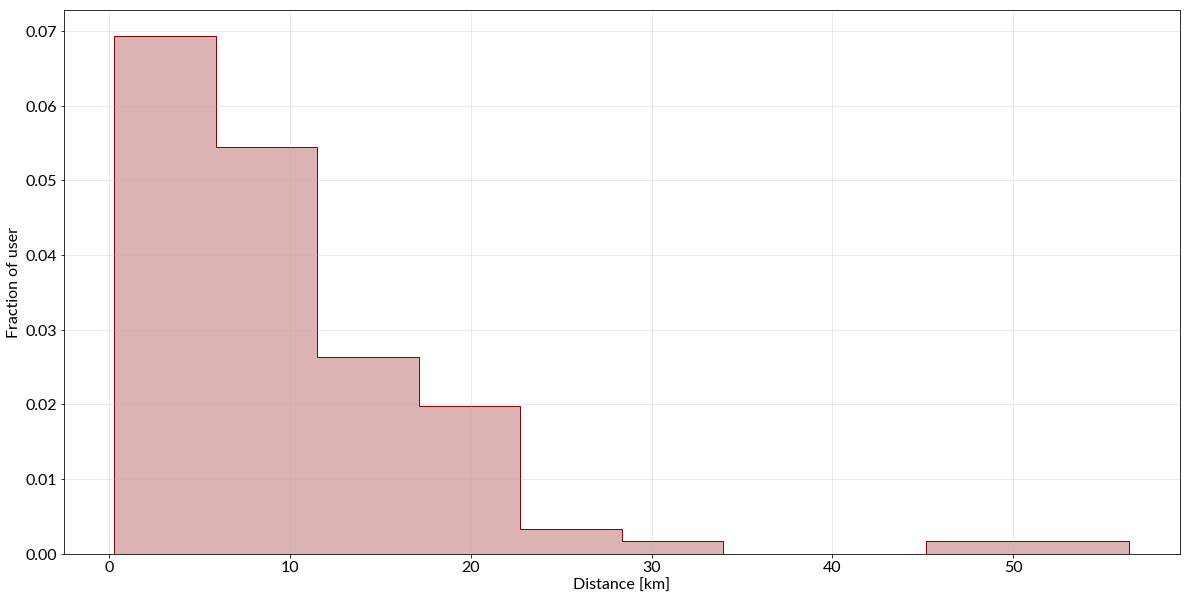

In [28]:
plt.hist(df['distance'].dropna(), density=True, color='darkred', alpha=0.3)
plt.hist(df['distance'].dropna(), density=True, color='darkred', histtype='step')
plt.xlabel('Distance [km]')
plt.ylabel('Fraction of user')
plt.grid(alpha=0.3)
plt.show()

As we can see most of the people run rather short distances (which was expected).

### Pie chart of cities by number of tweets

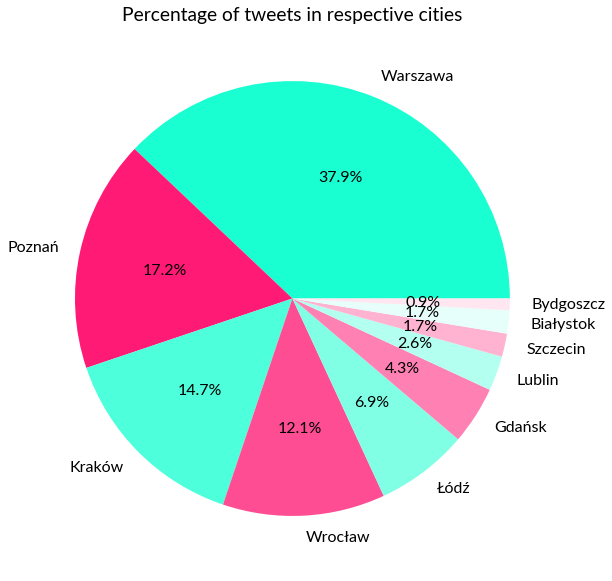

In [29]:
plt.pie(df['city'].value_counts(), 
        labels=df['city'].value_counts().index, 
        autopct='%1.1f%%', 
        colors=['#1affd1', '#ff1a75', '#4dffdb', '#ff4d94', '#80ffe5',
                '#ff80b3', '#b3fff0', '#ffb3d1', '#e6fffa', '#ffe6f0'])
plt.title('Percentage of tweets in respective cities')
plt.show()

We have most of the tweets from Warsaw, which is expected as it is the biggest city in our country (and probably the most technologicaly advanced).